### Required Imports and Installations

In [1]:
#!pip install xgboost
#!pip install yellowbrick
#!pip install ipywidgets
#!pip install pandas-profiling

#!jupyter nbextension enable --py widgetsnbextension

In [2]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import catboost
import tensorflow as tf
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

2022-05-15 12:32:33.948222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-15 12:32:33.948243: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Ingestion & Pre-Processing

In [3]:
con_evs = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-EVs.sqlite"))
con_game = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Gaming.sqlite"))
con_oil = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Oil.sqlite"))
con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech.sqlite"))
con_pnf = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-PnF.sqlite"))
con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-stock.sqlite"))
con_res = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))


cons = {
    "EVs": con_evs,
    "Gaming": con_game,
    "Oil": con_oil,
    "Tech": con_tech,
    "Pharma": con_pnf,
    "Food": con_pnf,
    "Stock": con_stock,
    "Results": con_res
}

In [4]:
tickers = {
    "EVs": ["TSLA", "LCID"],
    "Oil": ["COP", "XOM", "CVX"],
    "Pharma": ["PFE", "AZN", "MRNA"],
    "Food": ["MCD", "MDLZ", "PEP"],
    "Tech": ["GOOGL", "AAPL", "INTC"]
}

categories = ["EVs", "Oil", "Tech", "Pharma", "Food"]

#"Gaming": ["EA"]

#"Gaming": ["EA", "ATVI"],
#"Oil": ["COP", "XOM", "CVX", "ENB"],
#"Tech": ["GOOGL", "AAPL", "MSFT", "INTC"]

In [5]:
def load_datasets(cons, tickers, categories, reduce = False):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            if reduce == True:
                tweet_df = pd.read_sql_query(f"SELECT * from processed_tweets WHERE category='{category}'", cons["Results"])
                
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")

                tweet_df.sort_values(by=['date'])

                aggregate_dict = dict()

                for idx, row in tweet_df.iterrows():
                    key = f"{row['category']},{row['date']}"

                    if key in aggregate_dict:
                        aggregate_dict[key] = aggregate_dict[key] + row

                    else:
                        aggregate_dict[key] = row


                aggregate_dict_df = pd.DataFrame.from_dict(aggregate_dict, orient='index')   
                aggregate_dict_df.reset_index(drop=True, inplace=True)   
                aggregate_dict_df['date'] = aggregate_dict_df['date'].str.slice(0, 10)

                #print(aggregate_dict_df.head())

                aggregate_dict_df.drop(columns = ['category', 'ticker'], inplace=True)
                aggregate_dict_df["date"] = aggregate_dict_df["date"].astype("datetime64")

                tweet_dfs[ticker] = aggregate_dict_df.copy(deep=True)
                
            else:
                tweet_df = pd.read_sql_query(f"SELECT * from new_scored_tweets WHERE category='{category}'", cons["Results"])

                tweet_df = tweet_df.drop(columns = ['category'])
                tweet_df["date"] = tweet_df["date"].astype("datetime64")
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                
                tweet_dfs[ticker] = tweet_df.copy(deep=True)
            
            stock_df = pd.read_sql_query(f"SELECT * from stock_data WHERE ticker='{ticker}'", cons["Stock"])
            
            stock_df = stock_df.drop(columns = ['category', 'ticker'])

            stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
            stock_df["open"] = stock_df["open"].astype("float64")
            stock_df["close"] = stock_df["close"].astype("float64")
            stock_df["high"] = stock_df["high"].astype("float64")
            stock_df["low"] = stock_df["low"].astype("float64")

            stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
            
            stock_dfs[ticker] = stock_df.copy(deep=True)
            
            del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [6]:
tweet_dfs, stock_dfs = load_datasets(cons, tickers, categories, reduce = False)

In [7]:
a = tweet_dfs["TSLA"]

a

,date,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-04-07,405,29.760626,42.419716,33.819664,61.686187,105.406782,237.907026,55,92,258
1,2020-04-08,243,29.776691,47.333942,25.889368,64.262435,109.520843,69.216720,71,121,51
2,2020-04-09,209,29.311668,44.887577,28.800758,57.566045,100.556852,50.877107,57,118,34
3,2020-04-10,272,24.159784,47.111198,29.729010,39.036394,120.448533,112.515063,39,84,149
4,2020-04-11,514,29.267159,42.111918,28.620923,289.783706,153.905570,70.310696,382,68,64
...,...,...,...,...,...,...,...,...,...,...,...
718,2022-03-26,362,24.960136,79.639015,51.400856,49.414182,185.991661,126.594145,40,181,141
719,2022-03-27,269,21.682240,88.565294,51.752467,28.025453,142.857427,98.117120,26,132,111
720,2022-03-28,200,13.536305,79.159981,43.303711,16.151524,104.101375,79.747098,12,115,73
721,2022-03-29,262,26.068008,96.631897,63.300098,34.526736,123.377115,104.096144,33,132,97


In [8]:
b = stock_dfs["TSLA"]

b

,date,open,close,high,low
0,2020-03-30,102.0520,100.4260,103.3294,98.246
1,2020-03-31,100.2500,104.8000,108.5920,99.400
2,2020-04-01,100.8000,96.3120,102.7910,95.020
3,2020-04-02,96.2060,90.8940,98.8520,89.280
4,2020-04-03,101.9000,96.0020,103.0980,93.678
...,...,...,...,...,...
720,2022-03-20,904.8575,917.2175,934.1000,897.165
721,2022-03-21,914.9800,921.1600,942.8500,907.090
722,2022-03-22,930.0000,993.9800,997.8600,921.750
723,2022-03-23,979.9400,999.1100,1040.7000,976.400


In [9]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
            temp_stock_df = stock_dfs[ticker].copy(deep=True)

            temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
            temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
            
            
            merged_dfs[ticker] = temp_merged_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
            
            del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [10]:
def normalize_datasets(categories, tickers, merged_dfs, reduced = False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_norm_df = merged_dfs[ticker].copy(deep=True)
            
            temp_norm_df = temp_norm_df.drop(columns=['date'])

            temp_norm_df = scaler.fit_transform(temp_norm_df)
            
            if reduced == False: #For the complete datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
            else: #For the reduced datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = ['prev_open', 'ind_neg', \
                                                                    'ind_neu', 'ind_pos', 'close'])
            
            norm_dfs[ticker] = temp_norm_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
            
            del temp_norm_df
            
    return norm_dfs

In [11]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (717, 15) 

Data dimensions for LCID: (242, 15) 

Data dimensions for COP: (717, 15) 

Data dimensions for XOM: (717, 15) 

Data dimensions for CVX: (717, 15) 

Data dimensions for GOOGL: (714, 15) 

Data dimensions for AAPL: (714, 15) 

Data dimensions for INTC: (717, 15) 

Data dimensions for PFE: (730, 15) 

Data dimensions for AZN: (730, 15) 

Data dimensions for MRNA: (730, 15) 

Data dimensions for MCD: (730, 15) 

Data dimensions for MDLZ: (730, 15) 

Data dimensions for PEP: (730, 15) 



In [12]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = False)

Data dimensions for TSLA: (717, 14) 

Data dimensions for LCID: (242, 14) 

Data dimensions for COP: (717, 14) 

Data dimensions for XOM: (717, 14) 

Data dimensions for CVX: (717, 14) 

Data dimensions for GOOGL: (714, 14) 

Data dimensions for AAPL: (714, 14) 

Data dimensions for INTC: (717, 14) 

Data dimensions for PFE: (730, 14) 

Data dimensions for AZN: (730, 14) 

Data dimensions for MRNA: (730, 14) 

Data dimensions for MCD: (730, 14) 

Data dimensions for MDLZ: (730, 14) 

Data dimensions for PEP: (730, 14) 



In [13]:
merged_dfs['TSLA'].head()

,date,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,2020-04-07,109.0000,109.0900,113.0000,106.468,405,29.760626,42.419716,33.819664,61.686187,105.406782,237.907026,55,92,258
1,2020-04-08,110.8400,109.7680,111.4416,106.666,243,29.776691,47.333942,25.889368,64.262435,109.520843,69.216720,71,121,51
2,2020-04-09,112.4180,114.6000,115.0364,111.422,209,29.311668,44.887577,28.800758,57.566045,100.556852,50.877107,57,118,34
3,2020-04-10,115.2250,122.3950,122.7182,113.764,272,24.159784,47.111198,29.729010,39.036394,120.448533,112.515063,39,84,149
4,2020-04-11,116.6285,126.2925,126.5591,114.935,514,29.267159,42.111918,28.620923,289.783706,153.905570,70.310696,382,68,64


In [14]:
norm_dfs['TSLA'].head()

,open,close,high,low,count,ind_neg,ind_neu,ind_pos,wted_neg,wted_neu,wted_pos,neg_counts,neu_counts,pos_counts
0,0.000000,0.000000,0.001377,0.000000,0.081803,0.278674,0.176300,0.143917,0.012963,0.048889,0.241882,0.012069,0.029245,0.169668
1,0.001635,0.000605,0.000000,0.000178,0.043167,0.278874,0.211060,0.100014,0.013676,0.051495,0.058898,0.016010,0.042925,0.026316
2,0.003037,0.004916,0.003175,0.004461,0.035058,0.273078,0.193756,0.116132,0.011823,0.045817,0.039005,0.012562,0.041509,0.014543
3,0.005531,0.011871,0.009961,0.006570,0.050083,0.208868,0.209484,0.121271,0.006698,0.058417,0.105865,0.008128,0.025472,0.094183
4,0.006778,0.015348,0.013354,0.007624,0.107799,0.272524,0.174122,0.115136,0.076056,0.079609,0.060085,0.092611,0.017925,0.035319


In [15]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        for ticker in tickers[category]:
            plt.figure(figsize=(10,6))
            sns.heatmap(norm_dfs[ticker].corr(),cmap=random.choice(cmaps),annot=True)
            plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)
            plt.show()

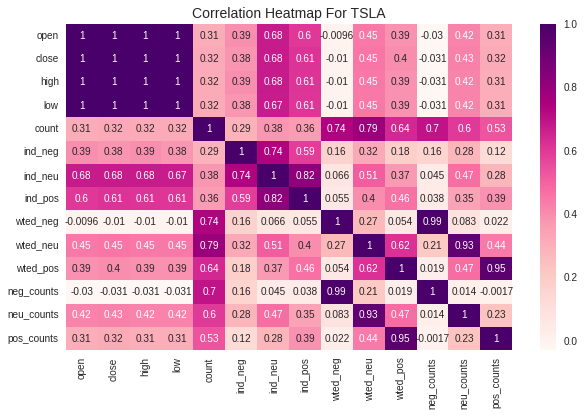

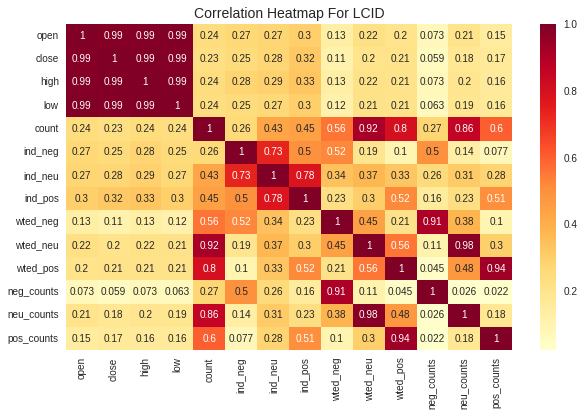

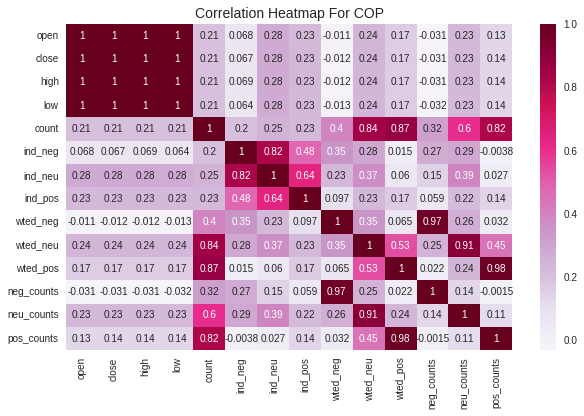

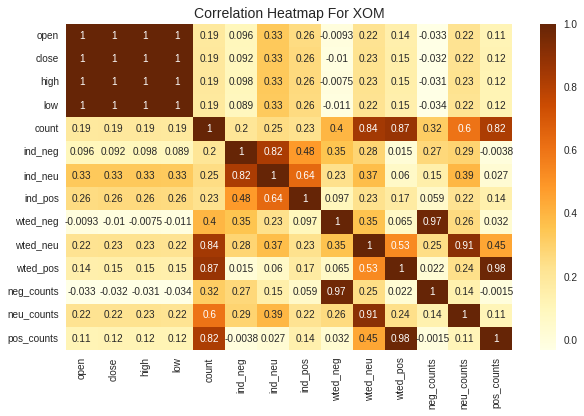

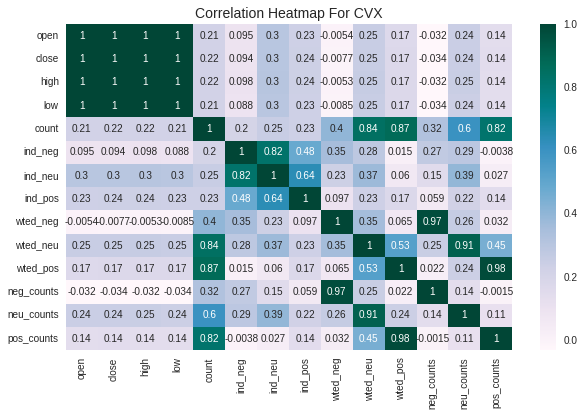

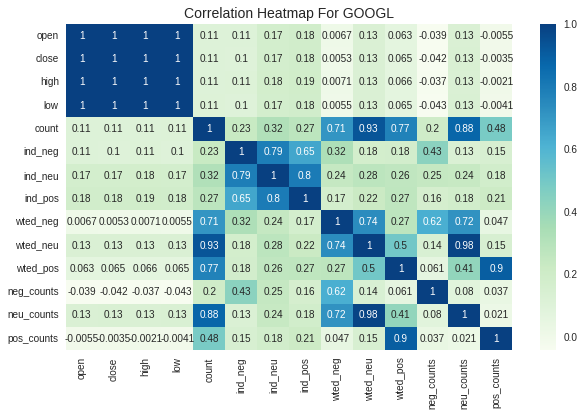

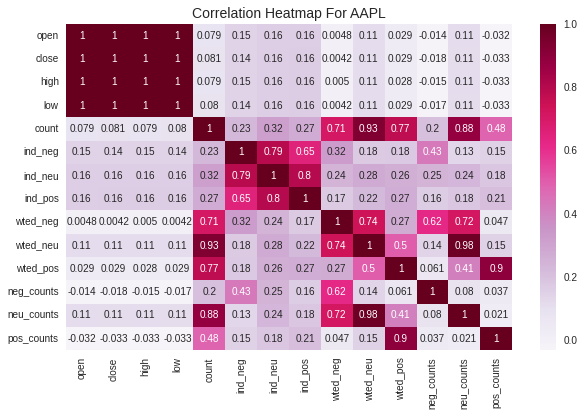

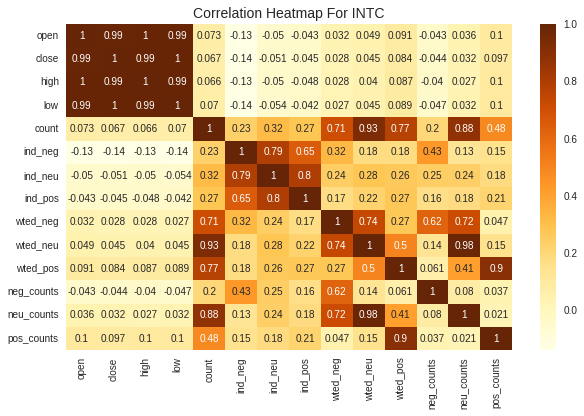

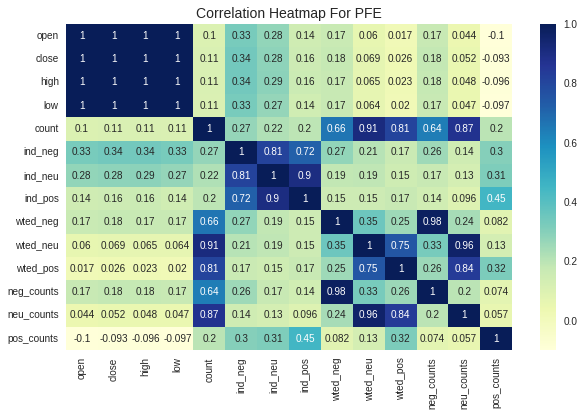

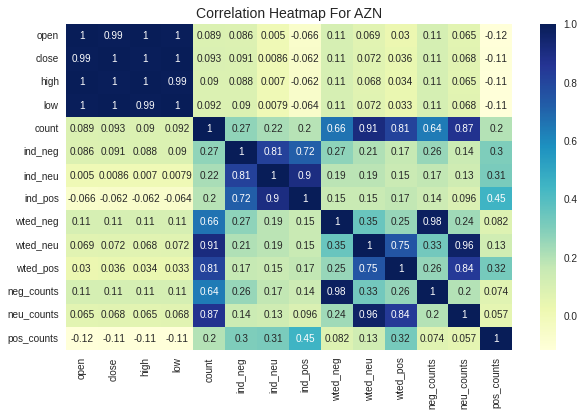

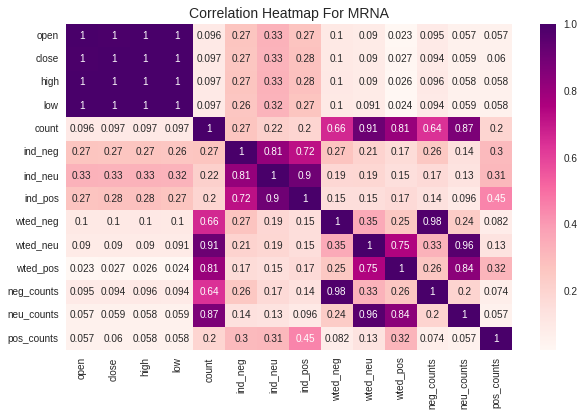

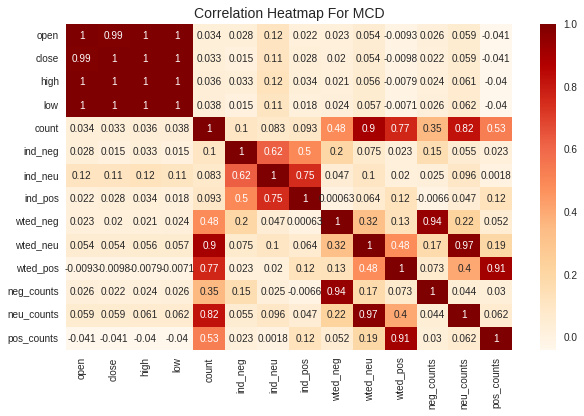

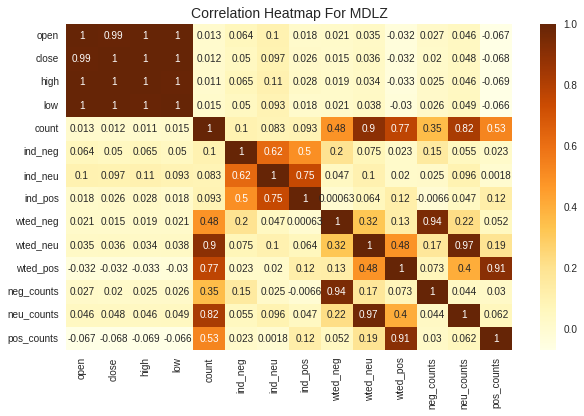

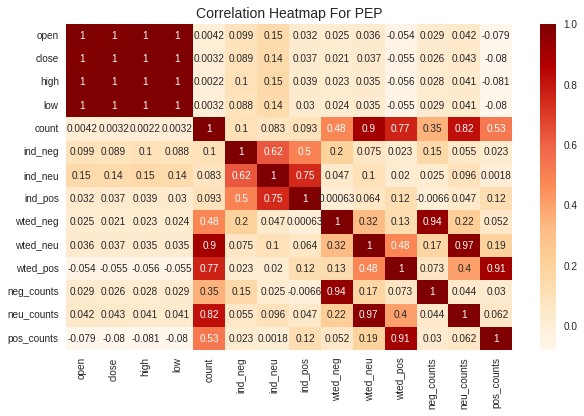

In [16]:
plot_corr_heatmaps(categories, tickers, norm_dfs)

In [17]:
def add_prev_day_open(merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
    
            t_df = merged_dfs[ticker].copy(deep = True)
            t_df = t_df.drop(columns = ['high', 'low', 'count', 'wted_neg', 'wted_neu', 'wted_pos', \
                                       'neg_counts', 'neu_counts', 'pos_counts'])

            t_minus1_df = t_df.copy(deep = True).drop(columns = ['close', 'ind_neg', 'ind_neu', 'ind_pos'])

            t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

            t_df = t_df.drop(columns=['open'])

            prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

            prev_open_df = prev_open_df[['date', 'open', 'ind_neg', 'ind_neu', 'ind_pos', 'close']]

            prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open'})
            
            prev_open_dfs[ticker] = prev_open_df
            
            del prev_open_df #Perform GC

    return prev_open_dfs

In [18]:
prev_open_dfs = add_prev_day_open(merged_dfs)

prev_open_dfs['TSLA']

,date,prev_open,ind_neg,ind_neu,ind_pos,close
0,2020-04-08,109.0000,29.776691,47.333942,25.889368,109.76800
1,2020-04-09,110.8400,29.311668,44.887577,28.800758,114.60000
2,2020-04-10,112.4180,24.159784,47.111198,29.729010,122.39500
3,2020-04-11,115.2250,29.267159,42.111918,28.620923,126.29250
4,2020-04-12,116.6285,17.075542,49.628338,34.296116,128.24125
...,...,...,...,...,...,...
711,2022-03-20,894.7350,23.400652,77.231102,43.368240,917.21750
712,2022-03-21,904.8575,29.305679,109.190102,64.504219,921.16000
713,2022-03-22,914.9800,27.974422,112.280266,95.745312,993.98000
714,2022-03-23,930.0000,35.987617,101.290970,71.721405,999.11000


In [19]:
prev_open_norm_dfs = normalize_datasets(categories, tickers, prev_open_dfs, reduced = True)

Data dimensions for TSLA: (716, 5) 

Data dimensions for LCID: (241, 5) 

Data dimensions for COP: (716, 5) 

Data dimensions for XOM: (716, 5) 

Data dimensions for CVX: (716, 5) 

Data dimensions for GOOGL: (713, 5) 

Data dimensions for AAPL: (713, 5) 

Data dimensions for INTC: (716, 5) 

Data dimensions for PFE: (729, 5) 

Data dimensions for AZN: (729, 5) 

Data dimensions for MRNA: (729, 5) 

Data dimensions for MCD: (729, 5) 

Data dimensions for MDLZ: (729, 5) 

Data dimensions for PEP: (729, 5) 



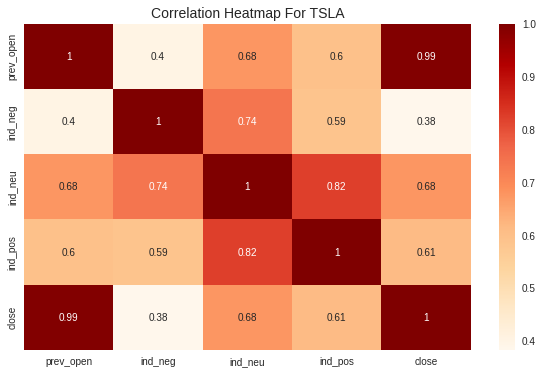

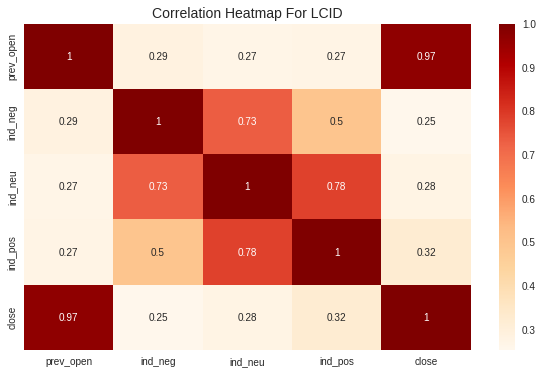

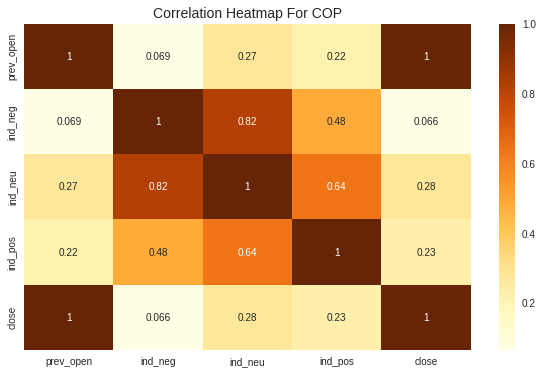

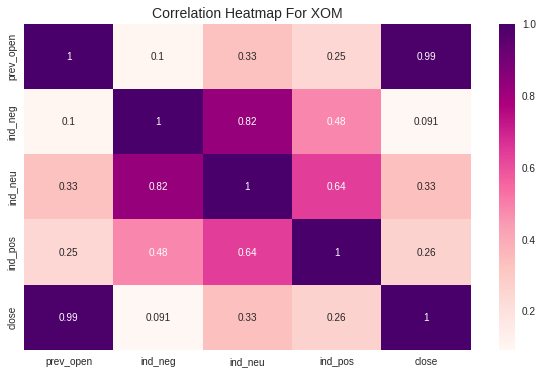

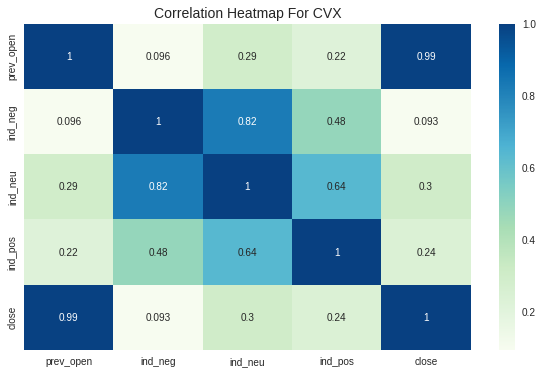

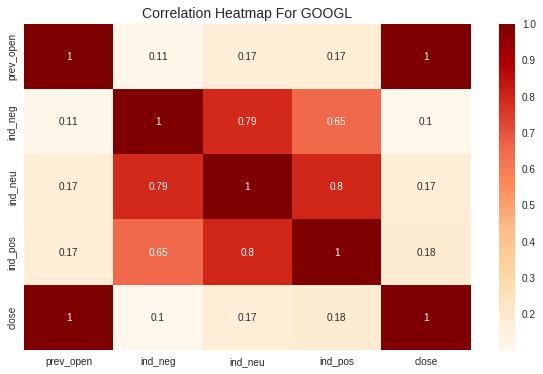

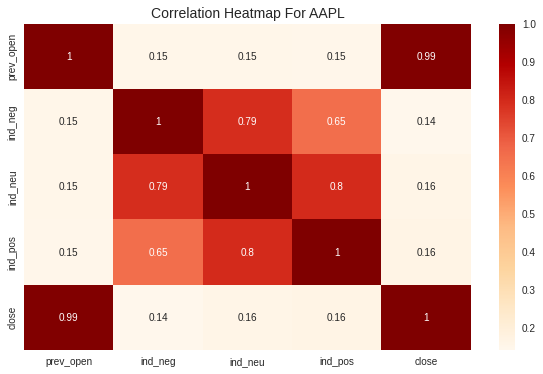

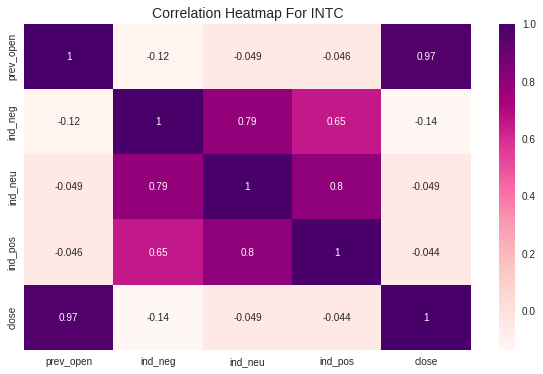

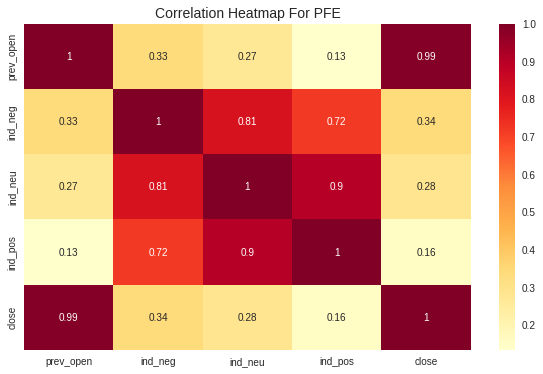

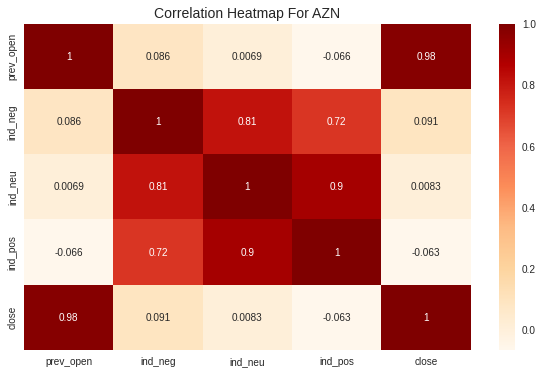

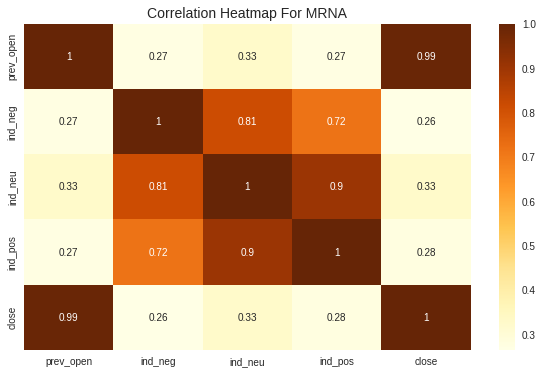

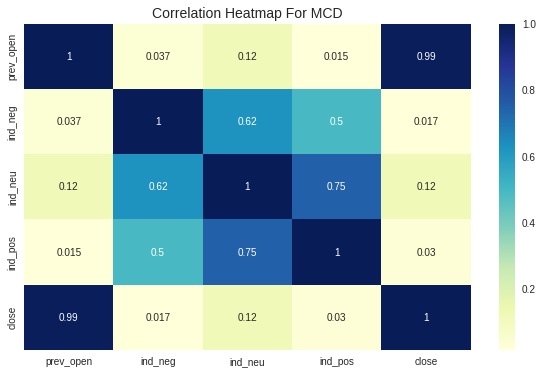

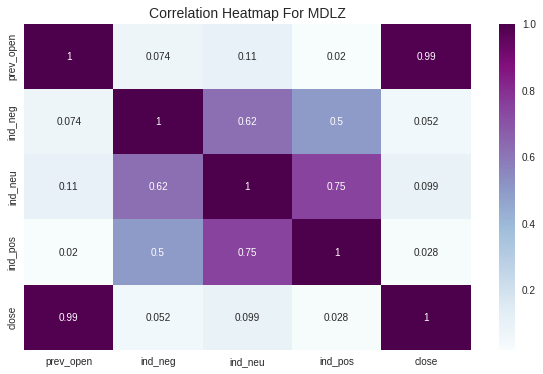

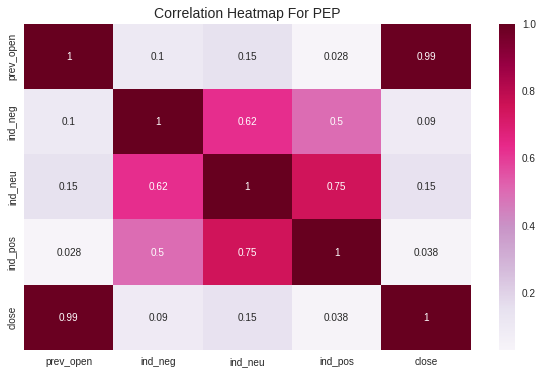

In [20]:
plot_corr_heatmaps(categories, tickers, prev_open_norm_dfs)

In [21]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [22]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [23]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.plot(predicted, color = 'green', label = 'Predicted Stock Price')
    plt.plot(test_label, color = 'red', label = 'Real Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [24]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"CatBoost Feature Importance - {ticker}")
    plt.show()

In [25]:
def get_train_test_set(norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = ['close'], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test

In [26]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [27]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
    params = {'depth': 2,
              'iterations': 200,
              'learning_rate': 0.03,
              'l2_leaf_reg': 3}


    model = CatBoostRegressor(**params, 
                                 loss_function='MAE',
                                 logging_level='Silent', 
                                 random_state=3,
                                )
    
    for category in categories:
        for ticker in tickers[category]:
            print(f"======CURRENTLY WORKING ON {ticker}======")
            
            X_train, X_test, y_train, y_test = get_train_test_set(norm_dfs[ticker], output_label='close')
            
            model.fit(X_train, y_train)
            
            print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
            print_metrics(model, X_train, X_test, y_test)
            plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker])
            
            
            print(f"======FINISHED WORKING ON {ticker}======")

In [28]:
# """ 
# Params for RMSE as the Loss Function
# params = {'depth': 10,
#          'l2_leaf_reg': 10,
#          'iterations': 200,
#          'learning_rate': 0.03}
# """

In [29]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, prev_open_dfs, output_label='close')

======CURRENTLY WORKING ON TSLA======


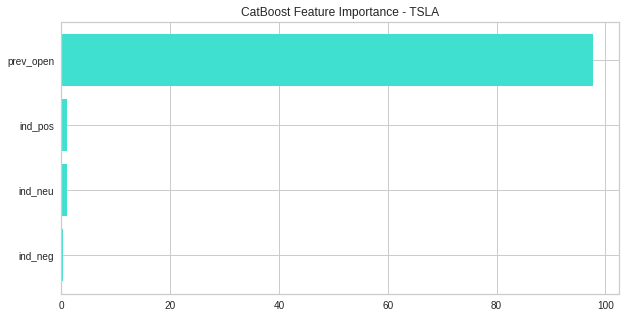

RMSE:			0.137519
MSE:			0.018911
MAE:			0.112048
R2 Score:		-0.743715
Adj. R2 Score:		-0.756016
Exp. Variance Score:	0.257726
Max Error:		0.311689


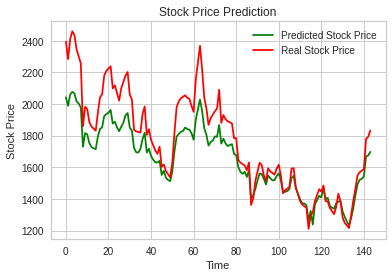

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON LCID======


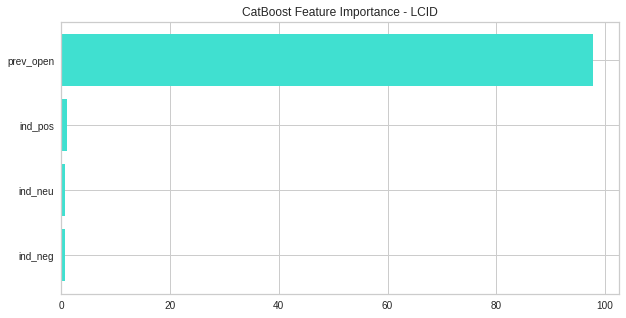

RMSE:			0.050176
MSE:			0.002518
MAE:			0.041038
R2 Score:		0.137543
Adj. R2 Score:		0.119094
Exp. Variance Score:	0.278556
Max Error:		0.109112


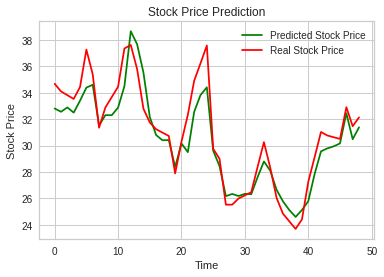

======FINISHED WORKING ON LCID======
======CURRENTLY WORKING ON COP======


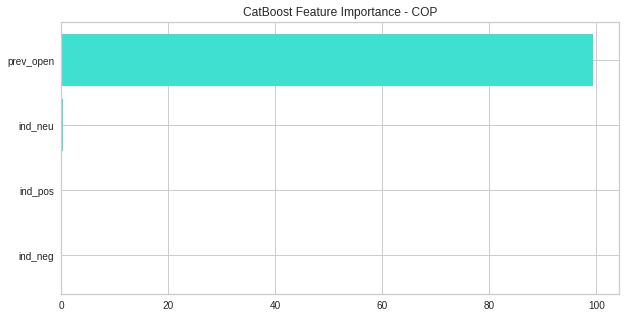

RMSE:			0.185591
MSE:			0.034444
MAE:			0.136021
R2 Score:		-0.729676
Adj. R2 Score:		-0.741878
Exp. Variance Score:	0.099417
Max Error:		0.405331


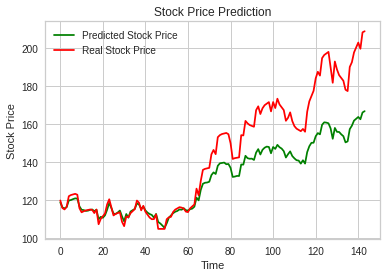

======FINISHED WORKING ON COP======
======CURRENTLY WORKING ON XOM======


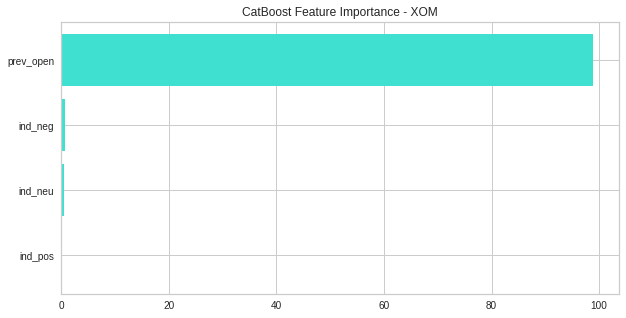

RMSE:			0.207525
MSE:			0.043067
MAE:			0.155786
R2 Score:		-0.899619
Adj. R2 Score:		-0.913020
Exp. Variance Score:	0.133200
Max Error:		0.442927


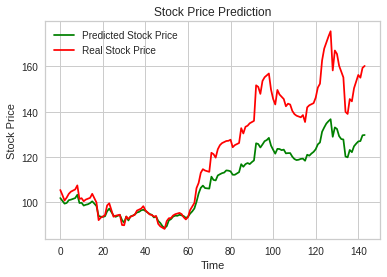

======FINISHED WORKING ON XOM======
======CURRENTLY WORKING ON CVX======


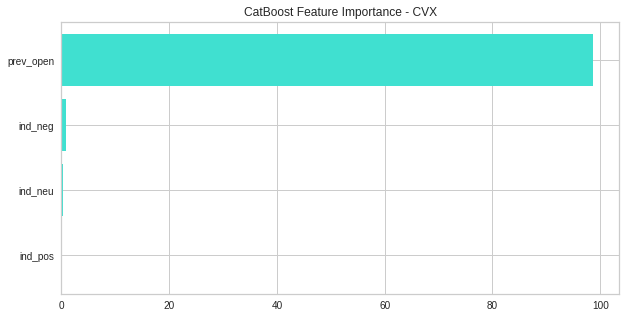

RMSE:			0.249315
MSE:			0.062158
MAE:			0.187788
R2 Score:		-1.316412
Adj. R2 Score:		-1.332753
Exp. Variance Score:	-0.002230
Max Error:		0.586544


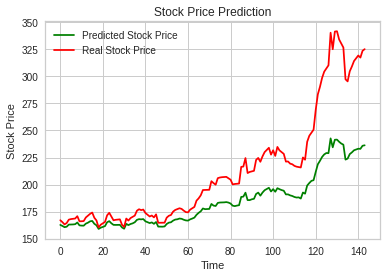

======FINISHED WORKING ON CVX======
======CURRENTLY WORKING ON GOOGL======


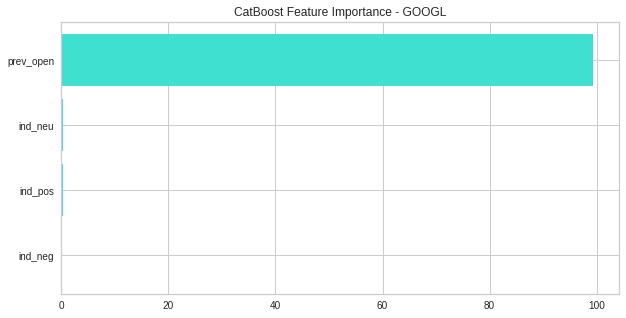

RMSE:			0.042587
MSE:			0.001814
MAE:			0.035430
R2 Score:		0.681696
Adj. R2 Score:		0.679442
Exp. Variance Score:	0.731183
Max Error:		0.100333


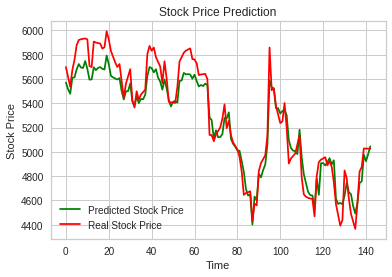

======FINISHED WORKING ON GOOGL======
======CURRENTLY WORKING ON AAPL======


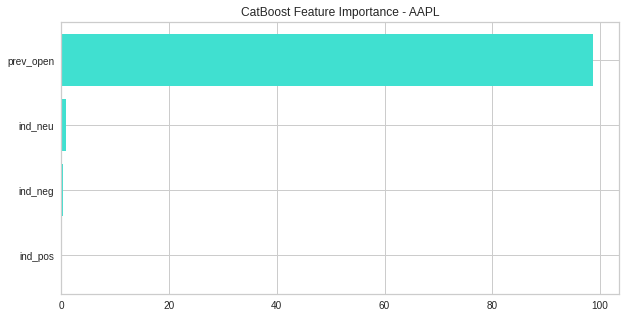

RMSE:			0.163480
MSE:			0.026726
MAE:			0.144576
R2 Score:		-3.335506
Adj. R2 Score:		-3.366199
Exp. Variance Score:	0.046749
Max Error:		0.282908


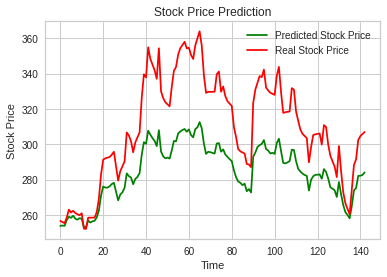

======FINISHED WORKING ON AAPL======
======CURRENTLY WORKING ON INTC======


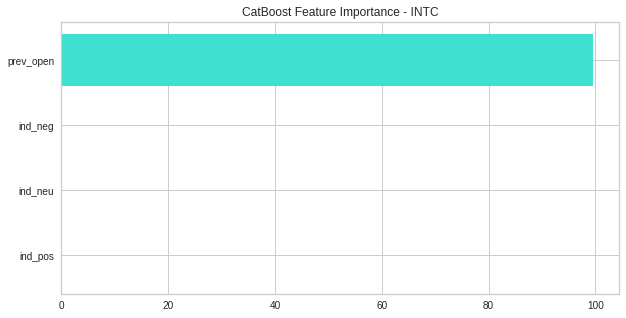

RMSE:			0.044621
MSE:			0.001991
MAE:			0.033633
R2 Score:		0.826666
Adj. R2 Score:		0.825443
Exp. Variance Score:	0.828230
Max Error:		0.132598


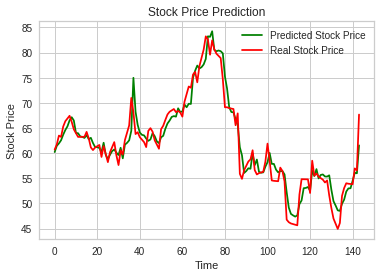

======FINISHED WORKING ON INTC======
======CURRENTLY WORKING ON PFE======


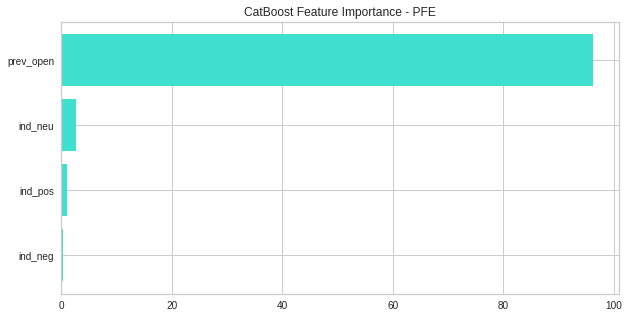

RMSE:			0.098611
MSE:			0.009724
MAE:			0.068899
R2 Score:		0.305408
Adj. R2 Score:		0.300601
Exp. Variance Score:	0.578131
Max Error:		0.302949


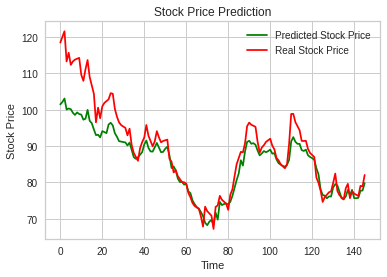

======FINISHED WORKING ON PFE======
======CURRENTLY WORKING ON AZN======


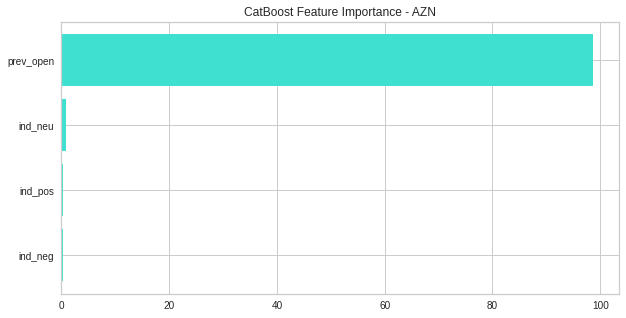

RMSE:			0.133853
MSE:			0.017917
MAE:			0.092266
R2 Score:		0.419259
Adj. R2 Score:		0.415240
Exp. Variance Score:	0.622668
Max Error:		0.377472


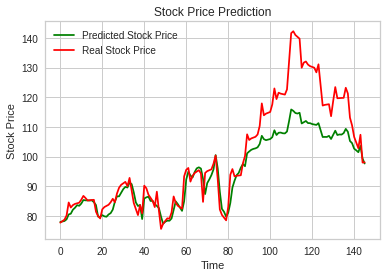

======FINISHED WORKING ON AZN======
======CURRENTLY WORKING ON MRNA======


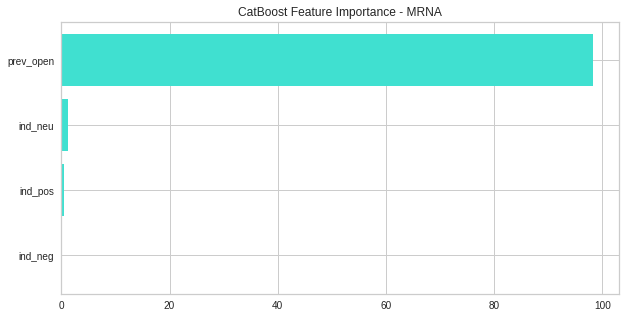

RMSE:			0.032429
MSE:			0.001052
MAE:			0.024133
R2 Score:		0.858120
Adj. R2 Score:		0.857138
Exp. Variance Score:	0.874590
Max Error:		0.141793


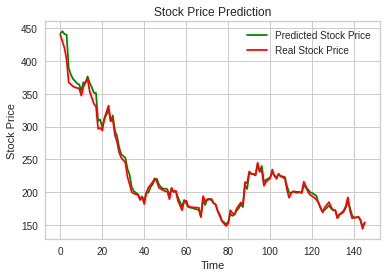

======FINISHED WORKING ON MRNA======
======CURRENTLY WORKING ON MCD======


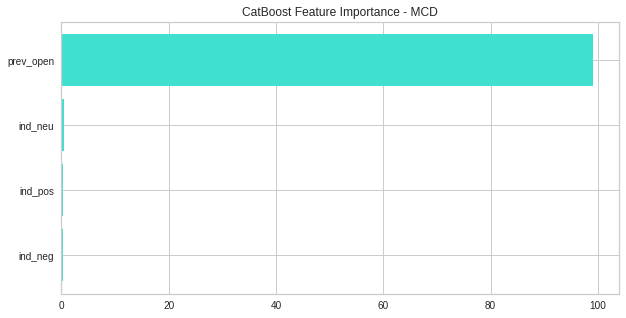

RMSE:			0.065748
MSE:			0.004323
MAE:			0.048185
R2 Score:		0.668945
Adj. R2 Score:		0.666654
Exp. Variance Score:	0.731283
Max Error:		0.153205


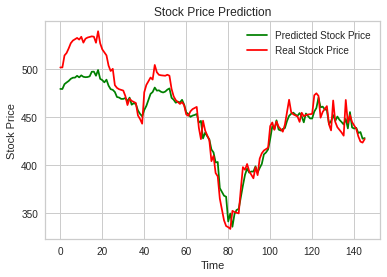

======FINISHED WORKING ON MCD======
======CURRENTLY WORKING ON MDLZ======


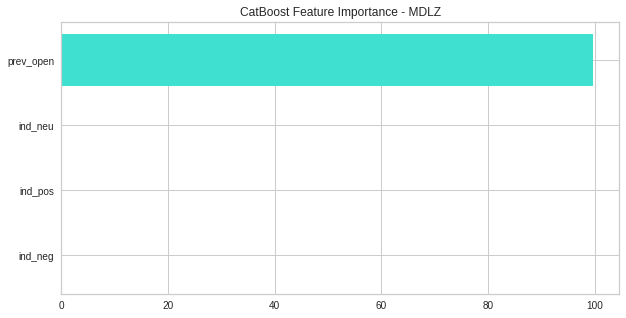

RMSE:			0.123055
MSE:			0.015143
MAE:			0.101195
R2 Score:		-0.120314
Adj. R2 Score:		-0.128067
Exp. Variance Score:	0.489312
Max Error:		0.236437


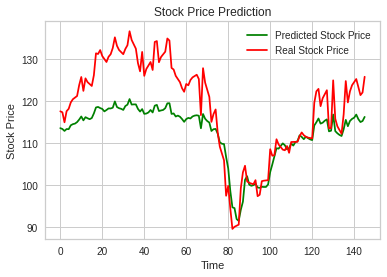

======FINISHED WORKING ON MDLZ======
======CURRENTLY WORKING ON PEP======


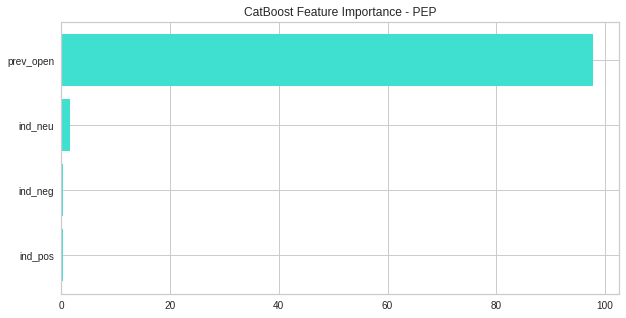

RMSE:			0.126978
MSE:			0.016123
MAE:			0.111421
R2 Score:		-0.645000
Adj. R2 Score:		-0.656384
Exp. Variance Score:	0.465416
Max Error:		0.240008


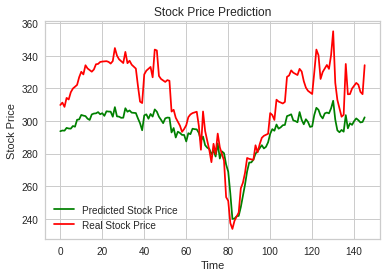

======FINISHED WORKING ON PEP======


In [30]:
train_and_test_model(categories, tickers, prev_open_norm_dfs, unscaled_op_labels)